# IU DeepNLP Reading Group Meeting #4
## PyTorch Tutorial

In [77]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor as T
from torch.autograd import Variable as V
from matplotlib import pyplot as plt
%matplotlib inline

# Task 1a- Neural Language Model

In [160]:
# We will use Shakespeare Sonnet 2
test_sentence_raw = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

vocab= set(test_sentence_raw)
vocab_dict= {word:i for i,word in enumerate(vocab)}
vocab_inv_dict= {i:word for word,i in vocab_dict.items()}
#converting to word ids is easier when feeding to model
test_sentence= list(map(lambda word:vocab_dict[word], test_sentence_raw))

# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams_raw = [ ([test_sentence_raw[i], test_sentence_raw[i+1]], test_sentence_raw[i+2]) for i in range(len(test_sentence_raw) - 2) ]
print(trigrams_raw[:3]) # print the first 3, just so you can see what they look like

trigrams= [([test_sentence[i], test_sentence[i+1]], test_sentence[i+2]) for i in range(len(test_sentence)- 2)]
print(trigrams[:3])

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[([20, 2], 91), ([2, 91], 63), ([91, 63], 85)]


In [161]:
#Hyperparams
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
VOCAB_SIZE= len(vocab)

class NLLM(nn.Module):
    #Actual Network code. Easy as pie!
    def __init__(self, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, context_size=CONTEXT_SIZE):
        super(NLLM, self).__init__()
        self.emb= nn.Embedding(vocab_size,embedding_dim)
        self.linear1=nn.Linear(context_size*embedding_dim,100)
        self.linear2=nn.Linear(100,vocab_size)
    
    def forward(self,inputs):
        #Pytorch always expects inputs to be minibatched
        h= self.emb(inputs) #Functions like a dictionary. Given inputs, returns corresponding embeddings
        h= h.view(1,-1) #This reshapes 2*10 into 1*20. -1 tells Pytorch to calculate dimensions given constraints
        h= F.relu(self.linear1(h))
        out= F.relu(self.linear2(h))
        logprobs= F.log_softmax(out)
        return logprobs

In [163]:
EPOCHS=100

model= NLLM()
#Hooking up the optimizer to the net's parameters. We will use this later to update
optimizer= optim.SGD(model.parameters(),lr=0.01) 
loss_criterion= nn.NLLLoss() #Negative log likelihood

losses=[]

for i in range(EPOCHS):
    total_loss=0
    for context,target in trigrams:
        #turn data into Tensors
        #context_var = autograd.Variable( torch.LongTensor(context_idxs) )
        inp= V(torch.LongTensor(context)) #embedding expects LongTensor. Default is float
        model.zero_grad()

        log_probs= model(inp)

        loss= loss_criterion(log_probs,
                             V(torch.LongTensor([target]))) #Pytorch needs Autograd Variables for backprop related calculations
        loss.backward()
        optimizer.step()
        
        total_loss+= loss.data.numpy() #Autograd var->Tensor->Numpy
    losses.append(total_loss)
    print(f"\rLoss at epoch {i+1}:{total_loss}",end='')

Loss at epoch 100:[ 317.0065918]

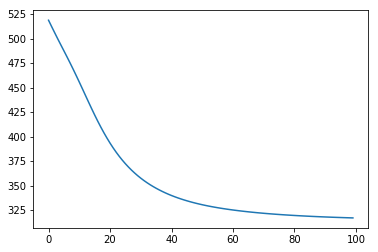

In [164]:
plt.plot(losses)

In [165]:
#Sample data using the model

def generate(priming_words, model, mode, length):
    """
    args:
        priming words is the first input fed to the language model
        model is the language model you're using
        mode can be 'max' or 'sample'
        length of generated sequence
    returns
    """
    context= priming_words.split()
    context= list(map(lambda word:vocab_dict[word], context))
    
    sentence= context[:]
    for i in range(length):
        #print(context)
        inp= V(torch.LongTensor(context))
        log_probs= model(inp)
        if mode=='max':
            _,argmax= torch.max(log_probs,1) #get index
            next_word= argmax.data.numpy().tolist()[0]
        else:
            pass
        sentence.append(next_word)
        context.pop(0)
        context.append(next_word)
    
    sentence= list(map(lambda word:vocab_inv_dict[word], sentence))
    return " ".join(sentence)

generate("Where all", model, 'max',10)

"Where all all were couldst answer 'This mine Shall sunken eyes, Shall"